In [59]:
import pandas as pd
import numpy as np

np.random.seed(42)
data = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [60]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [61]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

nominal_cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

class DynamicOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories='auto'):
        self.categories=categories
        self.encoder=OrdinalEncoder(categories=self.categories)

    def fit(self, X, y=None):
        self.encoder = OrdinalEncoder(categories=self.categories)
        self.encoder.fit(X)
        return self

    def set_params(self, **params):
        if 'categories' in params:
            self.categories = params['categories']
            self.encoder = OrdinalEncoder(categories=self.categories)
        return super().set_params(**params)

ordinal_cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                 OrdinalEncoder(categories=[
                                        ['no', 'Sometimes', 'Frequently', 'Always'],
                                        ['no', 'Sometimes', 'Frequently', 'Always']
                                 ]),
                                 StandardScaler())

num_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

In [63]:
from sklearn.compose import ColumnTransformer, make_column_selector
from copy import deepcopy

X, y = data.drop('NObeyesdad', axis=1), data['NObeyesdad']

preprocessing = ColumnTransformer([
    ('one_hot', nominal_cat_pipe, ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
    ('ordinal', ordinal_cat_pipe, ['CAEC', 'CALC']),
    ('num', num_pipe, make_column_selector(dtype_exclude='object'))
])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
for i in range(10):
    print(y[i])

1
1
1
5
6
1
1
1
1
1


In [64]:
X = preprocessing.fit_transform(X)
X = pd.DataFrame(X, columns=preprocessing.get_feature_names_out())
print(X.head())

   one_hot__Gender_Female  one_hot__Gender_Male  \
0                     1.0                   0.0   
1                     1.0                   0.0   
2                     0.0                   1.0   
3                     0.0                   1.0   
4                     0.0                   1.0   

   one_hot__family_history_with_overweight_no  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         1.0   
4                                         1.0   

   one_hot__family_history_with_overweight_yes  one_hot__FAVC_no  \
0                                          1.0               1.0   
1                                          1.0               1.0   
2                                          1.0               1.0   
3                                          0.0               1.0   
4                                          0.0            

In [65]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svc = SVC(probability=True, random_state=42)
random_forest = RandomForestClassifier(random_state=42)
log_reg = LogisticRegression(max_iter=1000, random_state=42)

svc.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

log_loss sprawdza jak dobre są przewidziane prawdopodobieństwa. Kara złe i zbyt pewne predykcje. Im mniej tym lepiej

In [66]:
print(log_loss(y_test, svc.predict_proba(X_test)))
print(log_loss(y_test, random_forest.predict_proba(X_test)))
print(log_loss(y_test, log_reg.predict_proba(X_test)))

0.23444223121804791
0.2839459917183126
0.4082646561713242


cross_val_score sprawdza celność, czyli ile procent przewidzianych labeli zgadza się z prawdziwymi

In [67]:
print(cross_val_score(SVC(random_state=42), X, y))
print(cross_val_score(RandomForestClassifier(random_state=42), X, y))
print(cross_val_score(LogisticRegression(max_iter=1000, random_state=42), X, y))

[0.70685579 0.93838863 0.92890995 0.94312796 0.95971564]
[0.72576832 0.97630332 0.98341232 0.98341232 0.98815166]
[0.70212766 0.91469194 0.89336493 0.91943128 0.91943128]


# Własne implementacje
Regresja liniowa z zamkniętą formułą

In [68]:
from sklearn.metrics import root_mean_squared_error

def closed_form_lin_reg(X, y):
    X = np.c_[np.ones((X.shape[0], 1)), X] # adding bias column
    pars = np.linalg.inv(X.T @ X) @ X.T @ y
    return pars

X_lin = data[['Height', 'Age']].to_numpy()
y_lin = data['Weight'].to_numpy()

X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(X_lin, y_lin, test_size=0.2, random_state=42)

pars = closed_form_lin_reg(X_lin_train, y_lin_train)
print(pars)
y_lin_pred = np.c_[np.ones((X_lin_test.shape[0], 1)), X_lin_test] @ pars

print(root_mean_squared_error(y_lin_test, y_lin_pred))

[-156.62010215  130.68210655    0.85271068]
22.743273289591187


In [69]:
from sklearn.linear_model import LinearRegression

lin_reg_sklearn = LinearRegression()
lin_reg_sklearn.fit(X_lin_train, y_lin_train)

y_lin_pred = lin_reg_sklearn.predict(X_lin_test)
print(root_mean_squared_error(y_lin_test, y_lin_pred))

22.74327328959121


Moja implementacja - praktycznie identyczny RMSE do sklearnowej

Nieużywana bo zbyt wysoka złożoność, ponadto działa tylko dla liniowych związków

Regresja softmax, bo przewidujemy wiele klas

In [70]:
from sklearn.metrics import accuracy_score

def softmax(x):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True)) # thanks to this we avoid too large exponentials, without changing the result of softmax
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

def cross_entropy_multiclass(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) #avoiding log(0) and log(1)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def softmax_regression(X, y, n_classes=7, learning_rate=0.01, iters=1000, batch_size=20, l1=0.0, l2=0.0):
    X = np.c_[np.ones((X.shape[0], 1)), X] # adding bias column

    y_one_hot = np.zeros((X.shape[0], n_classes))
    y_one_hot[np.arange(X.shape[0]), y] = 1

    pars = np.zeros((X.shape[1], n_classes))

    for _ in range(iters):
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i : i+batch_size]
            y_one_hot_batch = y_one_hot[i : i+batch_size]

            logits = X_batch @ pars
            probs = softmax(logits)

            gradient = X_batch.T @ (probs - y_one_hot_batch) / X_batch.shape[0]

            if l2 > 0:
                gradient += 2 * l2 * pars # derivative of pars^2

            if l1 > 0:
                gradient += l1 * np.sign(pars) # "derivative" of |pars|

            pars -= learning_rate * gradient

    return pars

def predict_softmax(X, pars):
    X = np.c_[np.ones((X.shape[0], 1)), X]
    probs = softmax(X @ pars)
    return np.argmax(probs, axis=1), probs

pars = softmax_regression(X_train, y_train)

y_pred_labels, y_pred_probs = predict_softmax(X_test, pars)

print(accuracy_score(y_test, y_pred_labels))

y_test_one_hot = np.zeros((len(y_test), 7))
y_test_one_hot[np.arange(len(y_test)), y_test] = 1

print(cross_entropy_multiclass(y_test_one_hot, y_pred_probs))

0.8747044917257684
0.41063453476331024


Moja implementacja działa porównywalnie, a nawet trochę lepiej od sklearn

# Validation set

In [71]:
X_train_n, X_val, y_train_n, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

svc = SVC(probability=True, random_state=42)
random_forest = RandomForestClassifier(random_state=42)
log_reg = LogisticRegression(max_iter=1000, random_state=42)

svc.fit(X_train_n, y_train_n)
random_forest.fit(X_train_n, y_train_n)
log_reg.fit(X_train_n, y_train_n)

LogisticRegression(max_iter=1000, random_state=42)

In [72]:
print(accuracy_score(y_val, svc.predict(X_val)))
print(accuracy_score(y_val, random_forest.predict(X_val)))
print(accuracy_score(y_val, log_reg.predict(X_val)))

0.8668639053254438
0.9437869822485208
0.8816568047337278


In [73]:
print(accuracy_score(y_test, svc.predict(X_test)))
print(accuracy_score(y_test, random_forest.predict(X_test)))
print(accuracy_score(y_test, log_reg.predict(X_test)))

0.91725768321513
0.9408983451536643
0.8723404255319149


# PyTorch

In [74]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

In [75]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)  # dense linear layer, with bias included

    def forward(self, x): #defines how input x moves through the model
        return self.linear(x)  # returning raw logits

In [76]:
def train_logistic_regression(X, y, learning_rate=0.01, batch_size=20, n_epochs=1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    input_dim = X.shape[1]
    output_dim = len(np.unique(y))

    model = LogisticRegressionModel(input_dim, output_dim)
    loss_func = nn.CrossEntropyLoss()  # applies softmax internally
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for _ in range(n_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()              # resetting gradients
            outputs = model(X_batch)           # raw logits
            loss = loss_func(outputs, y_batch) # cross entropy between logits and labels
            loss.backward()                    # calculating gradients with backprop
            optimizer.step()                   # updating weights

    return model

In [77]:
"""Zakomentowane żeby zbawić mój komputer od liczenia tego przy każdym Run All w notatniku

X_train_arr = X_train.to_numpy(dtype=np.float32)
X_test_arr = X_test.to_numpy(dtype=np.float32)

X_test_tensor = torch.tensor(X_test_arr, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

model = train_logistic_regression(X_train_arr, y_train)

with torch.no_grad(): # so we dont change gradient values
    logits = model(X_test_tensor)
    probs = torch.softmax(logits, 1)
    preds = torch.argmax(probs, 1)

print(accuracy_score(y_test, preds))"""

'Zakomentowane żeby zbawić mój komputer od liczenia tego przy każdym Run All w notatniku\n\nX_train_arr = X_train.to_numpy(dtype=np.float32)\nX_test_arr = X_test.to_numpy(dtype=np.float32)\n\nX_test_tensor = torch.tensor(X_test_arr, dtype=torch.float32)\ny_test_tensor = torch.tensor(y_test, dtype=torch.long)\n\nmodel = train_logistic_regression(X_train_arr, y_train)\n\nwith torch.no_grad(): # so we dont change gradient values\n    logits = model(X_test_tensor)\n    probs = torch.softmax(logits, 1)\n    preds = torch.argmax(probs, 1)\n\nprint(accuracy_score(y_test, preds))'

# Część 3

# Stratified KFold

In [78]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skf.split(X_train, y_train):
    X_train_n, X_test_n = X.iloc[train_index], X.iloc[test_index] # these are dataframes
    y_train_n, y_test_n = y[train_index], y[test_index] # these are np arrays

    pars = softmax_regression(X_train_n, y_train_n)

    y_pred_labels = predict_softmax(X_test_n, pars)[0]

    print(accuracy_score(y_test_n, y_pred_labels))

0.8206039076376554
0.8383658969804618
0.8291814946619217


# Regularyzacja
L1 (lasso) - zmniejszamy niektóre wagi do 0, efektywnie eliminując znaczenie części cech. Dodajemy do funkcji straty sumę wartości bezwzględnych wag

L2 (ridge) - zmniejszamy mniej istotne wagi do bardzo małych, ale różnych od 0 wartości. Dodajemy do f-cji straty sumę kwadratów wag - wyczulony na outlierów

Porównanie L1 i L2

In [79]:
models = {
    'no_reg': LogisticRegression(penalty=None, max_iter=10000),
    'l1': LogisticRegression(penalty='l1', max_iter=10000, solver='saga'),
    'l2': LogisticRegression(penalty='l2', max_iter=10000)
}

weights = {}
scores = {}

for name, mod in models.items():
    mod.fit(X_train, y_train)
    weights[name] = mod.coef_.ravel().copy()
    scores[name] = mod.score(X_test, y_test)

for name in models:
    print(f'{name}: \n acc = {scores[name]:.4f} \n L2 norm = {np.linalg.norm(weights[name]):.4f} \n nonzero count = {np.count_nonzero(weights[name])}')

no_reg: 
 acc = 0.9669 
 L2 norm = 645.2402 
 nonzero count = 175
l1: 
 acc = 0.9669 
 L2 norm = 77.1308 
 nonzero count = 75
l2: 
 acc = 0.8794 
 L2 norm = 20.7427 
 nonzero count = 175


Norma L2 to pierwiastek z sumy wag. Jest znacznie niższa po regularyzacji, ponieważ obie jej metody zmniejszają wagi. Ilość niezerowych wag dla l1 znacznie spada, ponieważ l1 zeruje dużo wag, a l2 jedynie obniża ich wartości do bliskich zera

In [80]:
weights = {
    'no_reg': softmax_regression(X_train, y_train),
    'l1': softmax_regression(X_train, y_train, l1=0.001),
    'l2': softmax_regression(X_train, y_train, l2=0.001)
}

for name, pars in weights.items():
    y_pred_labels = predict_softmax(X_test, pars)[0]
    print(f'{name}: acc = {accuracy_score(y_test, y_pred_labels)}')

no_reg: acc = 0.8747044917257684
l1: acc = 0.8747044917257684
l2: acc = 0.8132387706855791


# Wykresy zbieżności i analiza błędów

In [81]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score

X_train_n, X_valid, y_train_n, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_n, y_train_n)
valid_preds = log_reg.predict(X_valid)
test_preds = log_reg.predict(X_test)
print(f'valid: f1={f1_score(y_valid, valid_preds, average="macro")} \ntest: f1={f1_score(y_test, test_preds, average="macro")}')

valid: f1=0.878474219489573 
test: f1=0.8657662984587505


Nie wydaje się, aby był problem z underfittingiem ani overfittingiem

In [82]:
poly_feat = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_feat.fit_transform(X_train_n)
X_valid_poly = poly_feat.fit_transform(X_valid)
X_test_poly = poly_feat.fit_transform(X_test)
log_reg.fit(X_train_poly, y_train_n)
valid_preds = log_reg.predict(X_valid_poly)
test_preds = log_reg.predict(X_test_poly)
print(f'valid: f1={f1_score(y_valid, valid_preds, average="macro")} \ntest: f1={f1_score(y_test, test_preds, average="macro")}')

valid: f1=0.898025541602192 
test: f1=0.8977508350624729


Wynik uległ nieznacznej poprawie

Implementacja regresji supermax zaktualizowana o historię kosztu

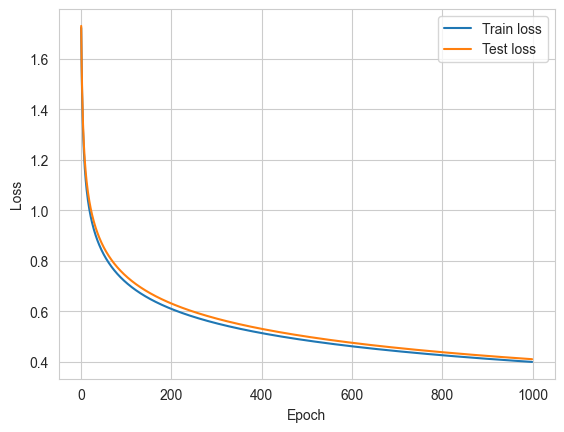

In [83]:
import matplotlib.pyplot as plt

def softmax_regression_with_history(X_train, X_test, y_train, y_test, n_classes=7, learning_rate=0.01, iters=1000, batch_size=20, l1=0.0, l2=0.0):

    X_train = np.c_[np.ones((X_train.shape[0],1)), X_train] # adding bias
    X_test = np.c_[np.ones((X_test.shape[0],1)), X_test]

    y_train_one_hot = np.zeros((X_train.shape[0], n_classes))
    y_train_one_hot[np.arange(X_train.shape[0]), y_train] = 1
    y_test_one_hot = np.zeros((X_test.shape[0], n_classes))
    y_test_one_hot[np.arange(X_test.shape[0]), y_test] = 1

    pars = np.zeros((X_train.shape[1], n_classes))

    train_losses = []
    test_losses  = []

    for _ in range(iters):
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_one_hot_batch = y_train_one_hot[i:i+batch_size]

            logits = X_batch @ pars
            probs  = softmax(logits)

            grad = X_batch.T @ (probs - y_one_hot_batch) / X_batch.shape[0]
            if l2 > 0:
                grad += 2 * l2 * pars # derivative of pars^2
            if l1 > 0:
                grad += l1 * np.sign(pars) # "derivative" of |pars|

            pars -= learning_rate * grad

        train_pred = softmax(X_train @ pars)
        test_pred  = softmax(X_test  @ pars)
        train_losses.append(cross_entropy_multiclass(y_train_one_hot, train_pred))
        test_losses.append(cross_entropy_multiclass(y_test_one_hot, test_pred))

    return pars, train_losses, test_losses

_, train_losses, test_losses = softmax_regression_with_history(X_train, X_test, y_train, y_test)

plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Na podstawie wykresu nie wydaje się, żeby ani underfitting ani overfitting były problemem

Sprawdźmy jak wygląda dla rozszerzonych cech

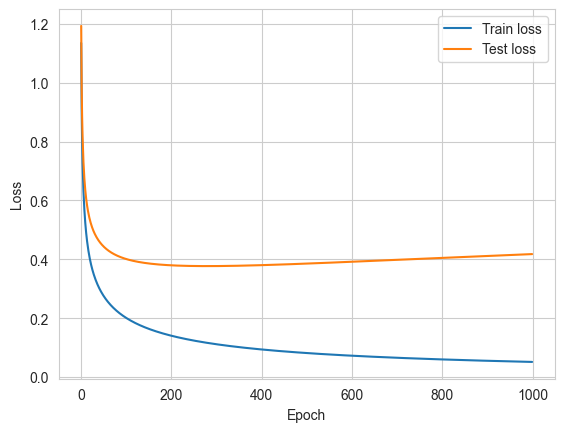

In [84]:
_, train_losses, test_losses = softmax_regression_with_history(X_train_poly, X_test_poly, y_train_n, y_test)

plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Overfitting - train loss maleje, a test loss rośnie

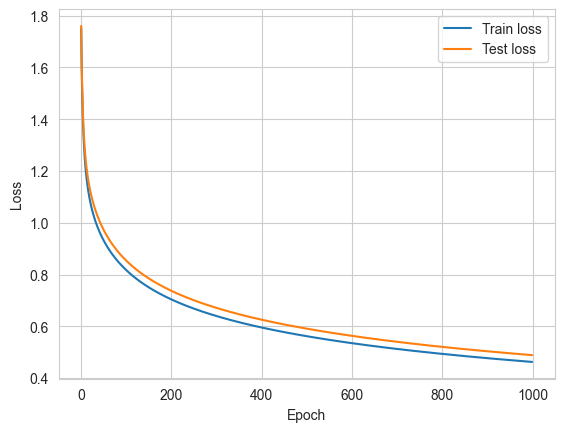

In [85]:
X_train_stripped = X_train.iloc[:, 10:]
X_test_stripped = X_test.iloc[:, 10:]

_, train_losses, test_losses = softmax_regression_with_history(X_train_stripped, X_test_stripped, y_train, y_test)

plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Gorszy performance niż na oryginalnym zbiorze

# Balansowanie zbiorów

In [91]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import precision_score, recall_score

smote = SMOTE(random_state=42)
tomek = TomekLinks(sampling_strategy='majority')

X_smote, y_smote = smote.fit_resample(X, y)
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
X_tomek, y_tomek = tomek.fit_resample(X, y)
X_tomek_train, X_tomek_test, y_tomek_train, y_tomek_test = train_test_split(X_tomek, y_tomek, test_size=0.2, random_state=42)

models = {'svc': SVC(random_state=42),
          'rfc': RandomForestClassifier(random_state=42),
          'log_reg': LogisticRegression(max_iter=1000, random_state=42)}

def print_scores(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_labels = model.predict(X_test)
        print(f'{name}: precision={precision_score(y_test, y_pred_labels, average="macro")}, recall={recall_score(y_test, y_pred_labels, average="macro")}, f1={f1_score(y_test, y_pred_labels, average="macro")}')

print('Original dataset')
print_scores(models, X_train, X_test, y_train, y_test)

print('SMOTE')
print_scores(models, X_smote_train, X_smote_test, y_smote_train, y_smote_test)

print('TomekLinks')
print_scores(models, X_tomek_train, X_tomek_test, y_tomek_train, y_tomek_test)

Original dataset
svc: precision=0.9210877365841047, recall=0.9188021168936471, f1=0.9194598934128327
rfc: precision=0.9444107786530519, recall=0.9448554414492758, f1=0.9444400358145033
log_reg: precision=0.8758577249143286, recall=0.8793652607787361, f1=0.8730525478649866
SMOTE
svc: precision=0.9104236028159708, recall=0.9076824095731659, f1=0.9085681371441048
rfc: precision=0.956139768714034, recall=0.9550657363682573, f1=0.9554994400294071
log_reg: precision=0.8884039463738711, recall=0.8870215653829099, f1=0.8837075361971004
TomekLinks
svc: precision=0.8918148737227684, recall=0.8871844762810362, f1=0.8882530339023421
rfc: precision=0.9324690980347203, recall=0.9244738397178195, f1=0.9266451441648221
log_reg: precision=0.8635302710685434, recall=0.8622588267764103, f1=0.860450471413034


Niewielkie zmiany. Ponieważ oryginalny dataset jest dobrze zbalansowany, dodatkowe balansowanie niewiele daje, w wielu przypadkach wręcz pogarsza wynik

Poniżej przykład użycia z moją implementacją regresji softmax

In [87]:
weights = softmax_regression(X_smote_train, y_smote_train)
y_pred_labels = predict_softmax(X_smote_test, weights)[0]
print(f'precision={precision_score(y_smote_test, y_pred_labels, average="macro")}, recall={recall_score(y_smote_test, y_pred_labels, average="macro")}, f1={f1_score(y_smote_test, y_pred_labels, average="macro")}')

precision=0.8787089719057927, recall=0.8766670550283997, f1=0.8728723107315934


# Optymalizacja hiperparametrów

In [88]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state=42)
rfc_params_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rfc_grid = GridSearchCV(rfc, rfc_params_grid, scoring='f1_macro', n_jobs=-1)

svc = SVC(random_state=42)
svc_params_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
svc_grid = GridSearchCV(svc, svc_params_grid, scoring='f1_macro', n_jobs=-1)

rfc_grid.fit(X_train, y_train)
svc_grid.fit(X_train, y_train)

y_pred_labels = rfc_grid.predict(X_test)
print(f'rfc\nBest params: {rfc_grid.best_params_} \nf1={f1_score(y_test, y_pred_labels, average="macro")}')

y_pred_labels = svc_grid.predict(X_test)
print(f'svc\nBest params: {svc_grid.best_params_} \nf1={f1_score(y_test, y_pred_labels, average="macro")}')

rfc
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100} 
f1=0.9444400358145033
svc
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'} 
f1=0.9726834830415393


W rfc praktycznie bez różnicy, svc zdecydowanie pomogło

# Ensemble methods

In [89]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegressionCV

voting_classifier = VotingClassifier(
    estimators=[
        ('log_reg', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    voting='soft', n_jobs=-1
) # soft voting considers probabilities

stacking_classifier = StackingClassifier(
    estimators=[
        ('log_reg', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=LogisticRegressionCV(max_iter=1000, random_state=42), # automatically selects the best regularization strength and type
    cv=3
)

models={
    'voting': voting_classifier,
    'stacking': stacking_classifier
}

print_scores(models, X_train, X_test, y_train, y_test)

voting: precision=0.9441302876853109, recall=0.9443235463090858, f1=0.9440821591893521
stacking: precision=0.9585196033555136, recall=0.9595816445856175, f1=0.9589910091022222


# Mixture of experts

In [90]:
def mixture_of_experts(X_train, X_test, y_train, experts, gating_model):
    X_train_n, X_valid, y_train_n, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    fitted_experts={}
    for name, model in experts:
        model.fit(X_train_n, y_train_n)
        fitted_experts[name] = model

    def _expert_preds(X):
        return np.column_stack([fitted_experts[name].predict(X) for name, _ in experts])

    valid_preds = _expert_preds(X_valid)
    correct = (valid_preds == y_valid.reshape(-1, 1)).astype(int)
    best_expert_idx = np.argmax(correct, axis=1)

    gating_model.fit(X_valid, best_expert_idx)

    test_preds = _expert_preds(X_test)
    picked_expert_idx = gating_model.predict(X_test)
    final_pred = np.array([test_preds[i, picked_expert_idx[i]] for i in range(len(X_test))])

    return final_pred

experts = [
    ('rfc', RandomForestClassifier(random_state=42)),
    ('svc', SVC(random_state=42)),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
]

y_pred_labels = mixture_of_experts(X_train, X_test, y_train, experts, LogisticRegressionCV(max_iter=1000, random_state=42))

print(f'MoE \nf1={f1_score(y_test, y_pred_labels, average="macro")}')

MoE 
f1=0.9319759365954081
